In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
from wordcloud import WordCloud

# Data Gathering

In [1]:
from google.colab import drive  
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd '/content/drive/My Drive/Fake_News'
!ls -la

/content/drive/My Drive/Fake_News
total 24044
-rw------- 1 root root     8882 Jun 24  2020 sample_submission.csv
-rw------- 1 root root  4799099 Jun 24  2020 test.csv
-rw------- 1 root root 19811997 Jun 24  2020 train.csv


In [4]:
# Load the train and test files
train = pd.read_csv("train.csv", sep='\t', encoding='utf-8')
test = pd.read_csv("test.csv", sep='\t', encoding='utf-8')

In [23]:
train.shape

(4987, 2)

Text(0.5, 1.0, 'Checking if data is balanced or not with a pie chart')

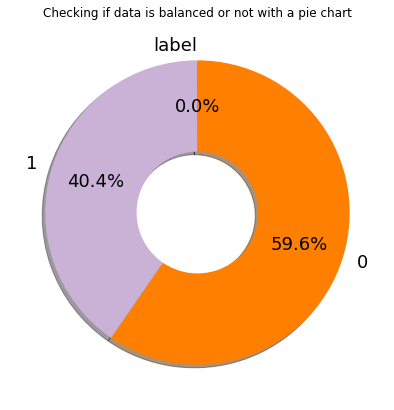

In [28]:
plt.figure(figsize=(7,7))

value_count = train["label"].value_counts()


plt.pie(value_count, labels=value_count.index ,
        startangle = 90 ,counterclock =False, wedgeprops = {'width' : 0.6},
        autopct='%1.1f%%', pctdistance = 0.7, textprops = {'color': 'black', 'fontsize' : 18}, 
        shadow = True,colors = sns.color_palette("Paired")[7:])
plt.title("Checking if data is balanced or not with a pie chart")

(-0.5, 399.5, 199.5, -0.5)

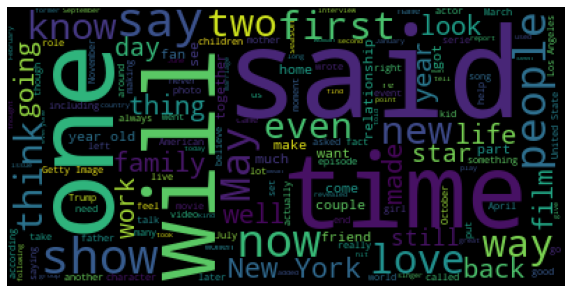

In [29]:
cloud = train.text.tolist()
cloud_st = " ".join(cloud)
plt.figure(figsize=(10,10))
plt.imshow(WordCloud().generate(cloud_st))
plt.axis("off")

# Data Preprocessing

In [6]:
import nltk #Import NLTK ---> Natural Language Toolkit
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [8]:


# create a function to tokenize the data
def preprocess_data(data):
  
  # 1. Tokenization
  tk = RegexpTokenizer('\s+', gaps = True)
  text_data = [] # List for storing the tokenized data
  for values in data.text:
    tokenized_data = tk.tokenize(values) # Tokenize the news
    text_data.append(tokenized_data) # append the tokenized data

  # 2. Stopword Removal

  # Extract the stopwords
  sw = stopwords.words('english')
  clean_data = [] # List for storing the clean text
  # Remove the stopwords using stopwords
  for data in text_data:
    clean_text = [words.lower() for words in data if words.lower() not in sw]
    clean_data.append(clean_text) # Appned the clean_text in the clean_data list
  
  # 3. Stemming

  # Create a stemmer object
  ps = PorterStemmer()
  stemmed_data = [] # List for storing the stemmed data
  for data in clean_data:
    stemmed_text = [ps.stem(words) for words in data] # Stem the words
    stemmed_data.append(stemmed_text) # Append the stemmed text
  
  # Flatten the stemmed data

  updated_data = []
  for data in stemmed_data:
    updated_data.append(" ".join(data))

  # TFID Vector object
  tfidf = TfidfVectorizer()
  tfidf_matrix = tfidf.fit_transform(updated_data)

  return tfidf_matrix

In [9]:
# Call the above function on the merged data
train_len = train.shape[0]
merged_data = pd.concat((train.drop('label', axis=1), test.drop('id', axis=1)), axis=0).reset_index().drop('index', axis=1)

In [10]:
# preprocess the merged data
preprocessed_data = preprocess_data(merged_data)

train_data = preprocessed_data[ : train_len]
test_data = preprocessed_data[train_len : ]

# Build ML-Models

In [12]:
X_train, X_test, y_train, y_test = train_test_split(train_data, train.label, test_size=0.2, random_state = 42)

In [15]:
# model
def compute_metrics(data, y_true, model_obj, model):

  # Make predictions
  y_pred = model_obj.predict(data)

  # Compute accuracy
  acc = accuracy_score(y_true = y_true, y_pred = y_pred)

  # Make DataFrame
  metrics = pd.DataFrame(data = np.array([acc]), index=[model], columns=['Accuracy Score'])
  return metrics

In [16]:
# 1. LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

# Model object
lr_reg = LogisticRegressionCV(Cs=20, cv=3, random_state=42)

# fit the model
lr_reg.fit(X_train, y_train)

LogisticRegressionCV(Cs=20, cv=3, random_state=42)

In [17]:
# Compute the Logistic Regression Metrics
lr_metrics =  compute_metrics(X_test, y_test, lr_reg, 'LogisticRegression')

In [18]:
lr_metrics_train =  compute_metrics(X_train, y_train, lr_reg, 'LogisticRegression')

In [19]:
lr_metrics

,Accuracy Score
LogisticRegression,0.778557


In [20]:
#2. Naive Bayes
from sklearn.naive_bayes import MultinomialNB

# Model Object
mnb = MultinomialNB(alpha=0.0)

# Fit the object
mnb.fit(X_train, y_train)

MultinomialNB(alpha=0.0)

In [21]:
# Compute metrics
mnb_metrics = compute_metrics(X_test, y_test, mnb, 'Naive Bayes')
mnb_metrics

,Accuracy Score
Naive Bayes,0.719439


In [22]:
# Concatenate all the metrics
model_metrics = pd.concat((lr_metrics, mnb_metrics), axis=0).sort_values(by='Accuracy Score', ascending=False)
model_metrics

,Accuracy Score
LogisticRegression,0.778557
Naive Bayes,0.719439
